In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
tf.get_logger().setLevel('ERROR')

In [3]:
# Setting the path to both the train and test data
data_dir_train = pathlib.Path("CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\")
data_dir_test = pathlib.Path("CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test\\")

In [4]:
#Counting the number of images in train directory
image_count = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of Images in Train is : ",image_count)
#Counting the number of images in test directory
image_count = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of Images in Test is : ",image_count)

Number of Images in Train is :  2239
Number of Images in Test is :  118


In [5]:
# Specifying Parameter to load images from directory using Keras
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Creating Training Dataset with 80% of the images
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 80-20 Split with 80% for training and 20% for validation
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Creating Validation Dataset with 20% of the images
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 80-20 Split with 80% for training and 20% for validation
  subset="validation", 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Getting Class names from the train.ds dataset and displaying the name and the number of classes
class_names = train_ds.class_names
print("The Number of Classes in the Training Dataset is :",len(class_names))
print("The label of the classes are as follow :")
for names in class_names:
    print(names)

The Number of Classes in the Training Dataset is : 9
The label of the classes are as follow :
actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


In [9]:
# Unbatching train_ds to check for class distribtion and display 1 image from every class
dataset_unbatched = tuple(train_ds.unbatch())

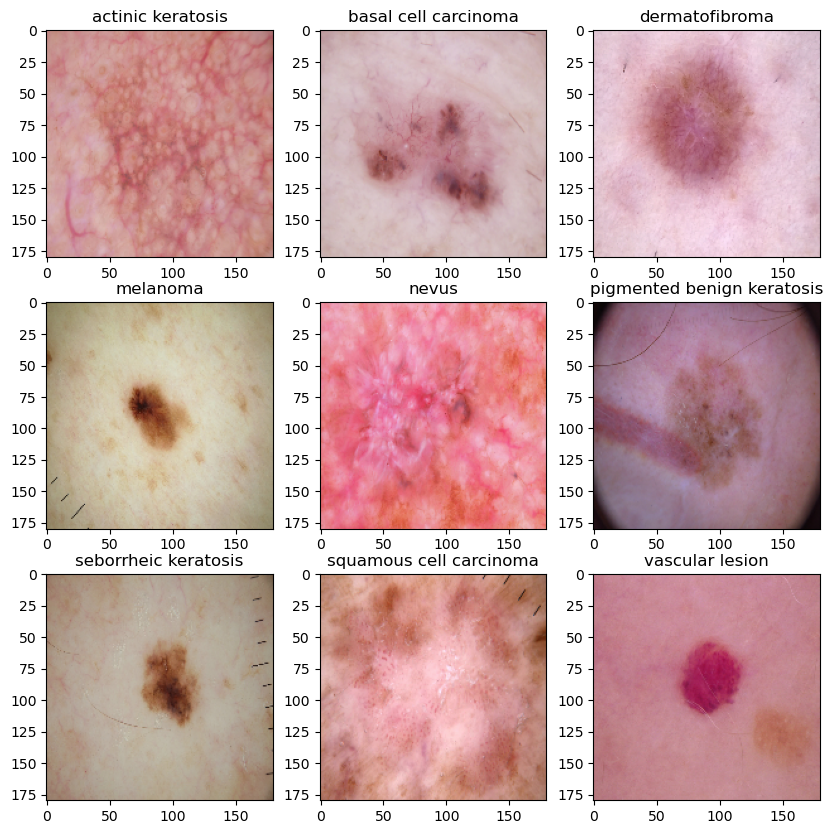

In [10]:
# Display 1 image from every class
plt.figure(figsize=(10, 10))
found=0 # Counter to stop iteration after 1 instance of each class(Total of 9) has been found
for (image,label) in dataset_unbatched:
    if(found==9):
        break
    else:
        if(label.numpy()==found):
            ax = plt.subplot(3, 3,found+1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(class_names[found])
            found +=1

In [11]:
#Checking class distribution in the train_ds dataset
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
count = count.sort_values(ascending=False)
count


pigmented benign keratosis    370
melanoma                      352
basal cell carcinoma          309
nevus                         277
squamous cell carcinoma       142
vascular lesion               115
actinic keratosis              92
dermatofibroma                 77
seborrheic keratosis           58
dtype: int64

<AxesSubplot:>

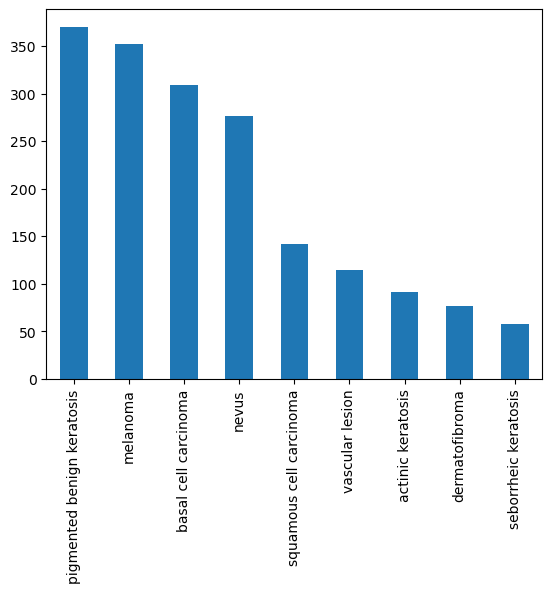

In [12]:
count.plot.bar(count)

In [13]:
## Class Imbalance seen##
#There is a huge class imbalance in the train.ds dataset. As can be seen from the graph and the list above.
#The range of number of images of from 370(in pigmented benign keratosis) to 58(in seborrheic keratosis)
#We will take care of this later during model building

In [14]:
# Checking Batch details
for image_batch, labels_batch in train_ds.take(1):
    print("The Details of each batch are as follow:")
    print("*"*20)
    print("The Number of images in each batch is :", image_batch.shape[0])
    print("The Height of images in the batch is :", image_batch.shape[1])
    print("The Width of images in the batch is :", image_batch.shape[2])
    print("The Number of Channels in each image is :", image_batch.shape[3])
    print("The Number of labels, which correspondent to the number of images - One Label per image in batch is : ",labels_batch.shape[0])
    print()
    break

The Details of each batch are as follow:
********************
The Number of images in each batch is : 32
The Height of images in the batch is : 180
The Width of images in the batch is : 180
The Number of Channels in each image is : 3
The Number of labels, which correspondent to the number of images - One Label per image in batch is :  32



In [15]:
# Reusable code to plot model accuracy anmd loss
#Repurposed from starter sheet
def plotmodel(modelhistory):
    acc = modelhistory.history['accuracy']
    val_acc = modelhistory.history['val_accuracy']

    loss = modelhistory.history['loss']
    val_loss = modelhistory.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')


    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    

In [16]:
# Setting Cache and Prefetch using Keras AUTOTUNE
#Please note: This will be called before every model so that the cache is shuffled
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
#Model 1 
# No Batch Normalization
# No Dropout
model_1 = Sequential([
    #Rescaling Layer
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    #Layer 1
    layers.Conv2D(16,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    #Layer 2
    layers.Conv2D(32,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    #Layer 3
    layers.Conv2D(64,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    #Flatten Layer
    layers.Flatten(),
    #Dense Layer
    layers.Dense(128,activation='relu'),
    #Softmax Layer
    layers.Dense(len(class_names),activation='softmax'),
])



In [18]:
# Compiling the model and specifying Optimizer,loss function and metric to be used
# Using sparse_categorical_crossentropy as loss as it is a multiclass classification model
model_1.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [19]:
#Checking Model Summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
#Running the model for 20 epochs
epochs = 20
history_1 = model_1.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 8s 48ms/step - loss: 1.9438 - accuracy: 0.2623 - val_loss: 1.7035 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5792 - accuracy: 0.4353 - val_loss: 1.4733 - val_accuracy: 0.5302
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4917 - accuracy: 0.4983 - val_loss: 1.4410 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3633 - accuracy: 0.5218 - val_loss: 1.4170 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2318 - accuracy: 0.5513 - val_loss: 1.4794 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.1478 - accuracy: 0.5921 - val_loss: 1.4217 - val_accuracy: 0.5570
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.1104 - accuracy: 0.6211 - val_loss: 1.3657 - val_accuracy: 0.5347
Epoch 8/20
56

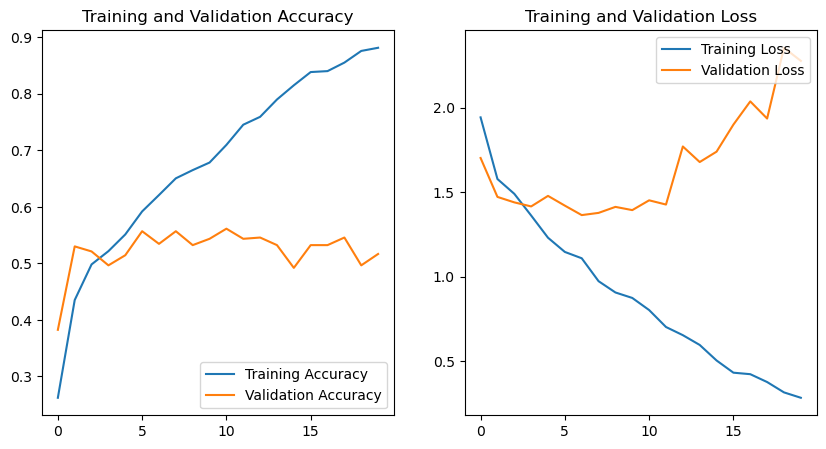

In [21]:
plotmodel(history_1)

Observation for model_1

From the graphs we can see that the model has very low accuracy on validation data but very high accuracy on training data., Also as the epochs increase the training loss is also decreasing very fast, this is a clear example of overfitting

Solving Overfit - Data Augmentation

One of the way we can try and solve overfitting is by data augmentation.

Here we will use keras to help us generate augmented data


In [22]:
# Setting the parameters for the augmentation
#Here Augmentation refers to the process of changing the original image by flipping, rotating, zoom (and/or)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
    layers.RandomZoom(0.2)
])

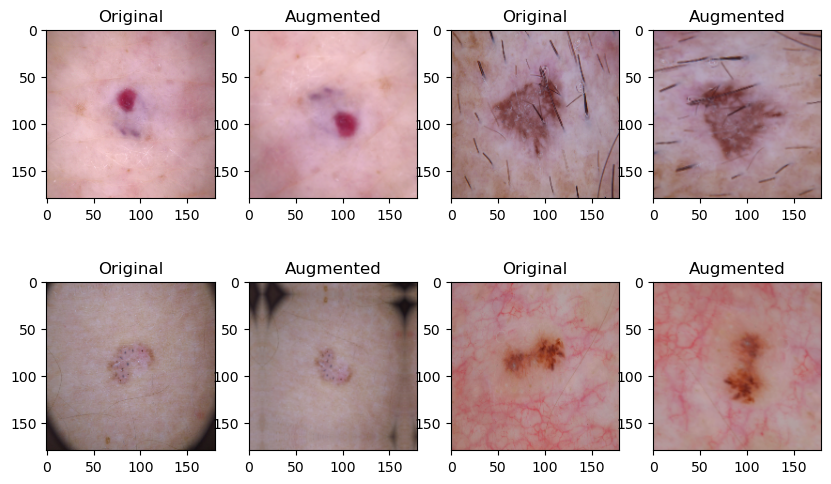

In [23]:
# Lets look at 4 random images after they have been augmented instead of just one
plt.figure(figsize=(10, 6))
position=1
for image, label in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 4, position)
        plt.title("Original")
        plt.imshow(image[i].numpy().astype("uint8"))
        augmented_image = data_augmentation(image[i])
        position +=1
        ax = plt.subplot(2, 4, position)
        plt.title("Augmented")
        plt.imshow(augmented_image.numpy().astype("uint8"))
        position +=1

In [24]:
#Let us apply the augmentation to the train_ds
# Also please note , augmentation will only be applied to training dataset and not validation or test


train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

In [25]:
# Setting Cache and Prefetch using Keras AUTOTUNE
#Please note: This will be called before every model so that the cache is shuffled
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
# Model_2
# No Batch normalization
# No Dropouts
#Please note data augmentation has been mapped above and will not be called during model building here

model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    #Layer 1
    layers.Conv2D(16,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    #Layer 2
    layers.Conv2D(32,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    #Layer 3
    layers.Conv2D(64,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    #Flatten Layer
    layers.Flatten(),
    #Dense Layer
    layers.Dense(128,activation='relu'),
    #Softmax Layer
    layers.Dense(len(class_names),activation='softmax'),
])

In [27]:
# Compiling the model and specifying Optimizer,loss function and metric to be used
# Using sparse_categorical_crossentropy as loss as it is a multiclass classification model
model_2.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [28]:
#Checking Model Summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [29]:
#Running the model for 20 epochs
epochs = 20
history_2 = model_2.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 5s 31ms/step - loss: 1.9336 - accuracy: 0.3142 - val_loss: 1.6391 - val_accuracy: 0.4273
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6145 - accuracy: 0.4319 - val_loss: 1.4838 - val_accuracy: 0.5034
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4983 - accuracy: 0.4777 - val_loss: 1.5412 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3877 - accuracy: 0.5061 - val_loss: 1.4456 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3247 - accuracy: 0.5234 - val_loss: 1.5404 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.2587 - accuracy: 0.5536 - val_loss: 1.4248 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 2s 28ms/step - loss: 1.1695 - accuracy: 0.5781 - val_loss: 1.6334 - val_accuracy: 0.5101
Epoch 8/20
56

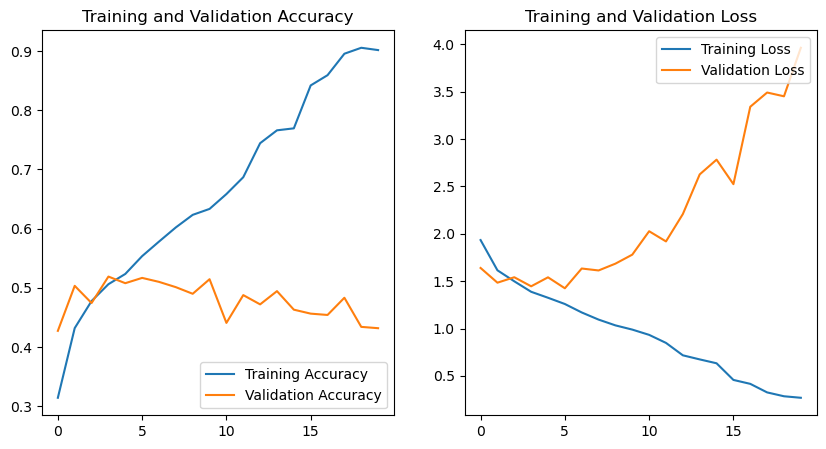

In [30]:
plotmodel(history_2)

 Observation for Model_2

The model is performing well on training dataset but is not performning well on validation. Our strategy to do in-place augmentation to prevent overfitting hasn't worked

Also as we noted before the building the 1st model there is a huge class imbalance in the training dataset and we will have to find a way to rectify this

In [31]:
#The number of images per class is as follows:
count

pigmented benign keratosis    370
melanoma                      352
basal cell carcinoma          309
nevus                         277
squamous cell carcinoma       142
vascular lesion               115
actinic keratosis              92
dermatofibroma                 77
seborrheic keratosis           58
dtype: int64

Solving class imbalance 

Here we will use the Augmentor library to generate augmented images from the original images that can be added to the dataset to ease the difference in number of data points per class

In [32]:
#install Augmentor
!pip install Augmentor



Defaulting to user installation because normal site-packages is not writeable


In [33]:
# Start the augmentor to add images to the train data directory
# Parameters used : Rotate -45 to +45 degree with a probability of 0.7 and zoom between 
# 1.1 to 1.25 with the probability of 0.3

path_to_training_dataset="CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.25)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse


Initialised with 114 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19DD60A6250>: 100%|█| 5


Initialised with 376 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19C7FA73160>: 100%|█| 5


Initialised with 95 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19D9581CA60>: 100%|█| 5


Initialised with 438 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x19DC370AB50>: 100%|█| 


Initialised with 357 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x19D


Initialised with 462 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19C7F9A3CA0>: 100%|█| 5


Initialised with 77 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x19C7FA01D60>: 100%|█| 


Initialised with 181 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19C7FAB55B0>: 100%|█| 5


Initialised with 139 image(s) found.
Output directory set to CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x19DD5


In [34]:
#Checking to see how many new images were added 
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [35]:
# Creating new training and validation dataset
# Checking new class distribution
#The train_ds and val_ds has to be rebuild as the data in the directory has increased

In [36]:
# Creating Training Dataset with 80% of the images
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 80-20 Split with 80% for training and 20% for validation
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [37]:
# Creating Validation Dataset with 20% of the images
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2, # 80-20 Split with 80% for training and 20% for validation
  subset="validation", 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
#Checking class distribution in the new train_ds dataset
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
count = count.sort_values(ascending=False)
count

pigmented benign keratosis    773
melanoma                      755
basal cell carcinoma          721
nevus                         677
squamous cell carcinoma       569
actinic keratosis             493
vascular lesion               493
seborrheic keratosis          456
dermatofibroma                455
dtype: int64

<AxesSubplot:>

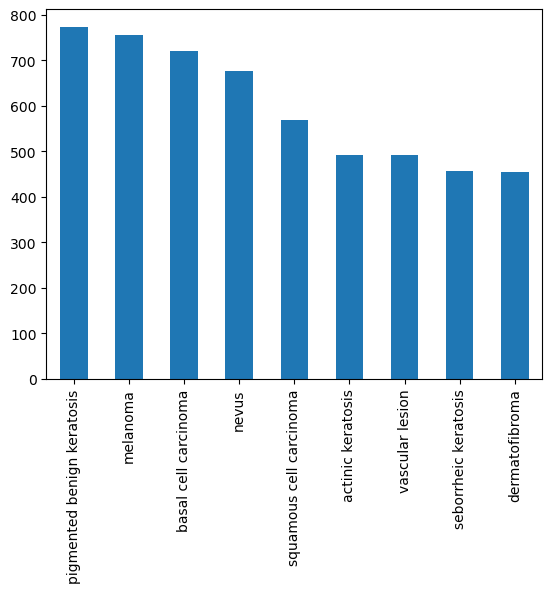

In [39]:
count.plot.bar(count)

In [40]:
# The class imbalance hasn't been totally solved but the imbalance has been reduced

In [41]:
# Setting Cache and Prefetch using Keras AUTOTUNE
#Please note: This will be called before every model so that the cache is shuffled
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
# Model_3
# Added batch normalization layer
# No Dropout
model_3 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    #Layer 1
    layers.Conv2D(16,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    #Layer 2
    layers.Conv2D(32,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    #Layer 3
    layers.Conv2D(64,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    #Flatten Layer
    layers.Flatten(),
    #Dense Layer
    layers.Dense(128,activation='relu'),
    #Softmax Layer
    layers.Dense(len(class_names),activation='softmax'),
])

In [43]:
# Compiling the model and specifying Optimizer,loss function and metric to be used
# Using sparse_categorical_crossentropy as loss as it is a multiclass classification model
model_3.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [44]:
#Checking model Summary
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 32)      

In [45]:
#Running the model for 30 epochs
epochs = 50
history_3 = model_3.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/50
169/169 [==============================] - 16s 47ms/step - loss: 2.3837 - accuracy: 0.3490 - val_loss: 42.5284 - val_accuracy: 0.1039
Epoch 2/50
169/169 [==============================] - 6s 35ms/step - loss: 1.3779 - accuracy: 0.4968 - val_loss: 13.2507 - val_accuracy: 0.1203
Epoch 3/50
169/169 [==============================] - 6s 35ms/step - loss: 1.1428 - accuracy: 0.5742 - val_loss: 2.9058 - val_accuracy: 0.3556
Epoch 4/50
169/169 [==============================] - 6s 35ms/step - loss: 0.9193 - accuracy: 0.6500 - val_loss: 1.5382 - val_accuracy: 0.4863
Epoch 5/50
169/169 [==============================] - 6s 35ms/step - loss: 0.7378 - accuracy: 0.7187 - val_loss: 1.5245 - val_accuracy: 0.5152
Epoch 6/50
169/169 [==============================] - 6s 35ms/step - loss: 0.5852 - accuracy: 0.7758 - val_loss: 1.5599 - val_accuracy: 0.5226
Epoch 7/50
169/169 [==============================] - 6s 35ms/step - loss: 0.4267 - accuracy: 0.8375 - val_loss: 1.4345 - val_accuracy: 0.5

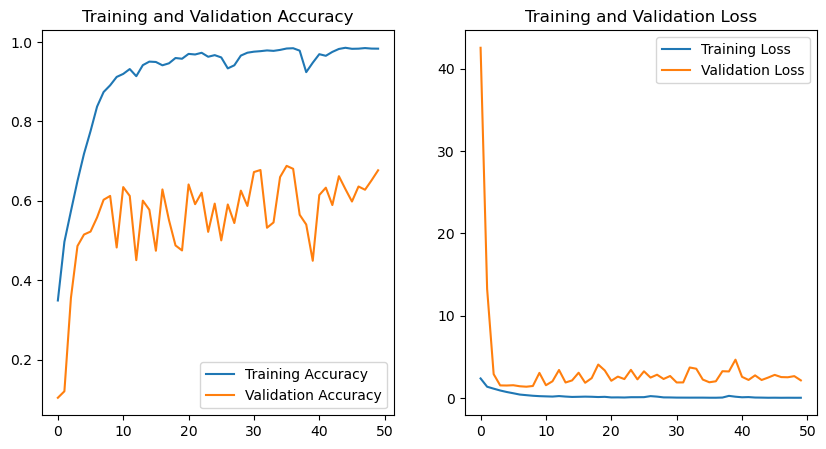

In [46]:
plotmodel(history_3)

 Observation for Model_3

The model is performing well on training dataset but is not performning well on validation.  But the handling the class balance has increased the validation accuracy considerably(43% to 67%). But there is still an issue of overfit

In [47]:
# Testing another model with different layers and configuration including dropouts

In [48]:
# Setting Cache and Prefetch using Keras AUTOTUNE
#Please note: This will be called before every model so that the cache is shuffled
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
# Model 4 
# Increasing layers compared to previous model
# Batch Normalization layer present
# Dropout layer added
model_4 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    #
    layers.Conv2D(16,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(16,3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    #
    layers.Conv2D(32,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    #
    layers.Conv2D(64,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64,3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    #Flatten Layer
    layers.Flatten(),
    #Dense Layer
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.25),
    #Softmax Layer
    layers.Dense(len(class_names),activation='softmax')
])

In [50]:
# Compiling the model and specifying Optimizer,loss function and metric to be used
# Using sparse_categorical_crossentropy as loss as it is a multiclass classification model
model_4.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [51]:
#Checking Model Summary
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 16)      2320      
                                                                 
 batch_normalization_4 (Batc  (None, 178, 178, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 16)      

In [52]:
epochs = 50
history_4 = model_4.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/50
169/169 [==============================] - 15s 77ms/step - loss: 2.5677 - accuracy: 0.2478 - val_loss: 15.7550 - val_accuracy: 0.1351
Epoch 2/50
169/169 [==============================] - 12s 72ms/step - loss: 1.8440 - accuracy: 0.2954 - val_loss: 11.1683 - val_accuracy: 0.1299
Epoch 3/50
169/169 [==============================] - 12s 73ms/step - loss: 1.8138 - accuracy: 0.2980 - val_loss: 2.8998 - val_accuracy: 0.3066
Epoch 4/50
169/169 [==============================] - 12s 73ms/step - loss: 1.7565 - accuracy: 0.3266 - val_loss: 2.7371 - val_accuracy: 0.3148
Epoch 5/50
169/169 [==============================] - 12s 72ms/step - loss: 1.7427 - accuracy: 0.3292 - val_loss: 1.6502 - val_accuracy: 0.4224
Epoch 6/50
169/169 [==============================] - 12s 73ms/step - loss: 1.6208 - accuracy: 0.3535 - val_loss: 1.4940 - val_accuracy: 0.4187
Epoch 7/50
169/169 [==============================] - 12s 73ms/step - loss: 1.5657 - accuracy: 0.3769 - val_loss: 1.7392 - val_accurac

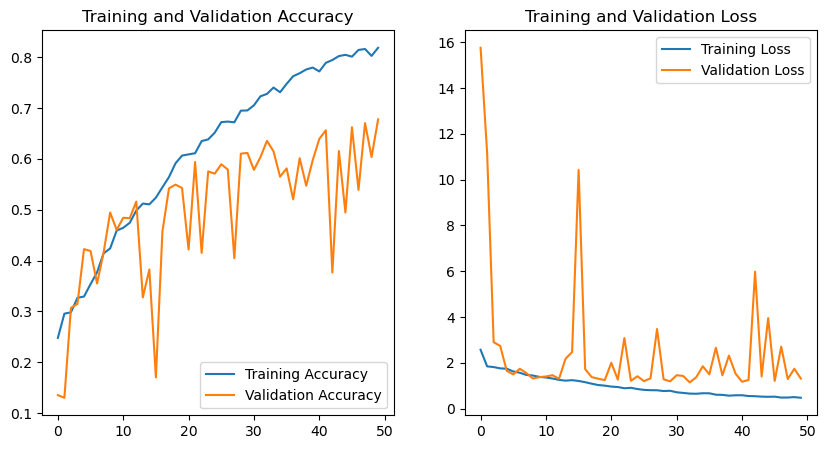

In [53]:
plotmodel(history_4)

Observations on Model 4

The training accuracy on model_4 is around 81.86% where as the validation accuracy is around 67.78%. We managed to bring down the overfitting compared to model_3 where the training accuracy was 98.35%. However the model still needs to be tweaked

In [54]:
# Model 5 - More Layers

In [55]:
# Setting Cache and Prefetch using Keras AUTOTUNE
#Please note: This will be called before every model so that the cache is shuffled
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
#Model_5
# More Layers added and combination of dropouts added
model_5 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    #
    layers.Conv2D(16,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(16,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),
    #
    layers.Conv2D(32,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    #
    layers.Conv2D(64,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),
    #
    layers.Conv2D(128,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    #
    layers.Conv2D(256,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),
    #
    layers.Conv2D(512,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    #
    layers.Conv2D(1024,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(1024,3,padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    #Flatten Layer
    layers.Flatten(),
    #Dense Layer
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.25),
    #Softmax Layer
    layers.Dense(len(class_names),activation='softmax')
])

In [57]:
model_5.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      2320      
                                                                 
 batch_normalization_10 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)      

In [58]:
epochs = 50
history_5 = model_5.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/50
169/169 [==============================] - 26s 136ms/step - loss: 2.4218 - accuracy: 0.3088 - val_loss: 2.6312 - val_accuracy: 0.1069
Epoch 2/50
169/169 [==============================] - 21s 127ms/step - loss: 1.6672 - accuracy: 0.3987 - val_loss: 2.1479 - val_accuracy: 0.2108
Epoch 3/50
169/169 [==============================] - 21s 127ms/step - loss: 1.4957 - accuracy: 0.4277 - val_loss: 1.8249 - val_accuracy: 0.3274
Epoch 4/50
169/169 [==============================] - 21s 127ms/step - loss: 1.4297 - accuracy: 0.4616 - val_loss: 1.5257 - val_accuracy: 0.3950
Epoch 5/50
169/169 [==============================] - 21s 127ms/step - loss: 1.3925 - accuracy: 0.4675 - val_loss: 1.7435 - val_accuracy: 0.3987
Epoch 6/50
169/169 [==============================] - 21s 127ms/step - loss: 1.2898 - accuracy: 0.5102 - val_loss: 1.8786 - val_accuracy: 0.4128
Epoch 7/50
169/169 [==============================] - 21s 127ms/step - loss: 1.2803 - accuracy: 0.5104 - val_loss: 1.8979 - val_ac

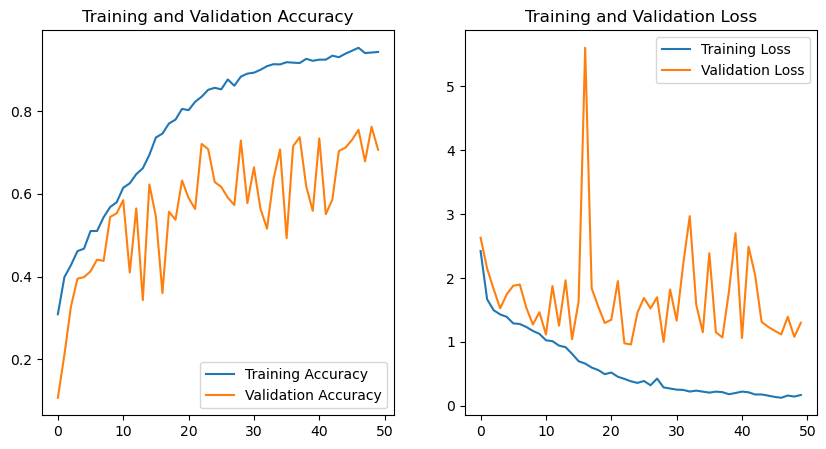

In [59]:
plotmodel(history_5)

Observation on Model_5

Model 5 took the longest time of all models here to fit. 
The model shows a slightly better accuracy on validation data compared to the previous model. Nevertheless it is still overfitting still.
We could increase the layers so and also do some l1 regularization, but we will stop model building now as have already built 5 models

In [70]:
###
#    Moment of truth : Lets see how the models created perform on test data
###

In [61]:
# Loading the test data to test_ds using keras
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,image_size=(img_height, img_width))

Found 118 files belonging to 9 classes.


In [62]:
# Function to predict on test data using every model created

def calculate_on_test(modelname):
    
    correct=0
    for name in class_names:
        Test_dir = os.path.join(data_dir_test, name, '*')
        Test_dir = glob(Test_dir)
        for x in range(len(Test_dir)):
            Test_image = load_img(Test_dir[x],target_size=(180,180,3))
            img = np.expand_dims(Test_image,axis=0)
            pred = modelname.predict(img)
            pred = np.argmax(pred)
            pred_class = class_names[pred]
            if(name==pred_class):
                correct +=1
    print("Number of images from the test set that were classified correctly by Model  : ",correct)
    percent=correct/118*100
    print("Which is ",percent,"percent of the whole testset")

In [63]:
#Checking classification on different models created


In [64]:
# Checking Model 1 
calculate_on_test(model_1)

1/1 [==============================] - 0s 16ms/step
Number of images from the test set that were classified correctly by Model  :  42
Which is  35.59322033898305 percent of the whole testset


In [65]:
# Checking Model 2
calculate_on_test(model_2)

1/1 [==============================] - 0s 20ms/step
Number of images from the test set that were classified correctly by Model  :  26
Which is  22.033898305084744 percent of the whole testset


In [66]:
# Checking Model 3
calculate_on_test(model_3)

1/1 [==============================] - 0s 18ms/step
Number of images from the test set that were classified correctly by Model  :  44
Which is  37.28813559322034 percent of the whole testset


In [67]:
# Checking Model 4
calculate_on_test(model_4)

1/1 [==============================] - 0s 19ms/step
Number of images from the test set that were classified correctly by Model  :  44
Which is  37.28813559322034 percent of the whole testset


In [68]:
# Checking Model 5
calculate_on_test(model_5)

1/1 [==============================] - 0s 20ms/step
Number of images from the test set that were classified correctly by Model  :  53
Which is  44.91525423728814 percent of the whole testset


In [69]:
#Model 5 performed the best on test data, predicting 53 classes correctly for 118 images (44.91%)